# Intravoxel incoherent motion (IVIM) imaging

Intra-voxel incoherent motion (IVIM) is a 2-compartment model that separates diffusion signal contributions originating from blood flow and Brownian diffusion *(Le Bihan et al. 1988)*. The model consists of 2 Ball compartments (isotropic Gaussian), each fitting the blood flow and diffusion volume fractions and diffusivities, respectively. Changes in e.g. blood volume fraction has been linked to many pathologies such as the vasculature in tumor tissue *(Le Bihan 2018)*.

\begin{align}
 E_{\textrm{IVIM}}= \underbrace{f_{\textrm{blood}}\overbrace{E_{\textrm{iso}}(\lambda_{\textrm{Blood}})}^{\textrm{Ball}}}_{\textrm{Blood}} + \underbrace{f_{\textrm{Diffusion}}\overbrace{E_{\textrm{iso}}(\cdot|\lambda_{\textrm{Diffusion}})}^{\textrm{Ball}}}_{\textrm{Diffusion}}
\end{align}

Because the apparent diffusivity of blood flow is much higher than that of Brownian motion, the optimization bounds for the diffusivities of the two Balls are disjoint; the diffusivies of the diffusion compartment range
between [0.5 - 6]e-3 $mm^2/s$ (results in more precise fit according to *(Gurney-Champion et al. 2016)*), and those of the blood compartment range between [6 - 20]e-3 $mm^2/s$ (following *(Park et al. 2017)*). 

The separability of blood and diffusion signal hinges on the observation that the blood-flow signal is negligible at b-values above 200-400 s/mm^2, but it does have a constribution below that bvalue (and to the b0).
    
Many different optimization strategies have been proposed to fit the IVIM model *(Wong et al. 2018, Gurney-Champion et al. 2018)*, of which in this example we will use Dmipy to implement and fit two:
- Following *(Wong et al. 2018)*, a two-step optimization based on the approach that first fits the 'diffusion' diffusivity by fitting a single Ball compartment to the signal where all b-values below b=400$s/mm^2$ have been truncated. Fixing this initial diffusivity, the 2-compartment model is then fitted to the whole signal.
- Following *(Gurney-Champion et al. 2018)*, they found simply fixing $\lambda_{blood}=7e-9 mm^2/s$ results in the second-best IVIM fitting performance (after fancy Bayesian fitting).

We compare the second IVIM algorithm with the one available in Dipy, and evaluate/compare the fitted parameter maps and fitting errors.

## Implementing Fixed Dstar IVIM using Dmipy

The fixed D-star IVIM implementation is very simple. We set the blood diffusivity to 7e-9 $m^2/s$ and fit the model as usual.

We'll use the same example dataset and acquisition scheme that Dipy uses as well:

### Load IVIM acquisition scheme and data

In [1]:
from dipy.data.fetcher import read_ivim
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy, acquisition_scheme_from_bvalues
img, gtab = read_ivim()
scheme_ivim = gtab_dipy2dmipy(gtab, b0_threshold=1e6, min_b_shell_distance=1e6)
scheme_ivim.print_acquisition_info

data = img.get_data()
data_slice = data[90: 155, 90: 170, 33, :]
test_voxel = data_slice[0, 0]

Dataset is already in place. If you want to fetch it again please first remove the folder /home/rutger/.dipy/ivim 
Acquisition scheme summary

total number of measurements: 21
number of b0 measurements: 1
number of DWI shells: 20

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |N/A                      |N/A        |N/A       |N/A  
1           |1         |10              |N/A                      |N/A        |N/A       |N/A  
2           |1         |20              |N/A                      |N/A        |N/A       |N/A  
3           |1         |30              |N/A                      |N/A        |N/A       |N/A  
4           |1         |40              |N/A                      |N/A        |N/A       |N/A  
5           |1         |60              |N/A                      |N/A        |N/A       |N/A  
6           |1         |80              |N/A                      |N/A        |N/A       |N/A  


/home/rutger/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/acquisition_scheme.py:860: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.


Notice that this scheme has 1 b-value per "shell" for different b-values.

The D*-Fixed IVIM implementation can be implemented as follows:

In [2]:
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.signal_models.gaussian_models import G1Ball
ivim_mod = MultiCompartmentModel([G1Ball(), G1Ball()])
ivim_mod.set_fixed_parameter(
    'G1Ball_2_lambda_iso', 7e-9)  # Following Gurney-Champion 2016
ivim_mod.set_parameter_optimization_bounds(
    'G1Ball_1_lambda_iso', [.5e-9, 6e-9])  # Following Gurney-Champion 2016
ivim_fit_Dfixed = ivim_mod.fit(
    acquisition_scheme=scheme_ivim,
    data=test_voxel)

We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.00300788879395 seconds
Fitting of 1 voxels complete in 0.524432182312 seconds.
Average of 0.524432182312 seconds per voxel.


We also fit the Dipy IVIM implementation as a reference

In [3]:
from dipy.reconst.ivim import IvimModel
ivimmodel = IvimModel(gtab)
ivim_fit_dipy = ivimmodel.fit(test_voxel)

Finally we can visualize the signal fits to this test voxel for the different IVIM algorithms. Note they're very similar.

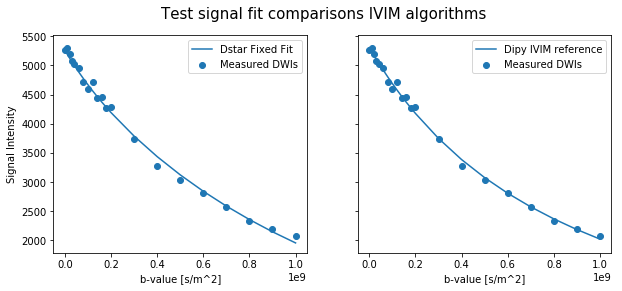

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=[10, 4], sharey=True)
fig.suptitle('Test signal fit comparisons IVIM algorithms', fontsize=15)
axs[0].set_ylabel('Signal Intensity')
axs[0].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[0].plot(scheme_ivim.bvalues, ivim_fit_Dfixed.predict()[0], label='Dstar Fixed Fit')
axs[1].scatter(scheme_ivim.bvalues, test_voxel, label='Measured DWIs')
axs[1].plot(scheme_ivim.bvalues, ivim_fit_dipy.predict(gtab), label='Dipy IVIM reference')
[ax.legend() for ax in axs]
[ax.set_xlabel('b-value [s/m^2]') for ax in axs];

## Parameter map comparison Dstar_fixed, and Dipy reference

To properly evaluate the two algorithms we fit them to the same example slice as in the dipy IVIM example.

Note that in practice we can import custom (prepared) multi-compartment models directly:

In [5]:
from dmipy.custom_optimizers.intra_voxel_incoherent_motion import ivim_Dstar_fixed
from time import time
ivim_fit_dmipy_fixed = ivim_Dstar_fixed(scheme_ivim, data_slice)
dipy_start = time()
ivim_fit_dipy = ivimmodel.fit(data_slice)
print('Dipy computation time: {} s'.format(time() - dipy_start))

Starting IVIM Dstar-fixed algorithm.
We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.00655007362366 seconds
Fitting of 5200 voxels complete in 19.0747060776 seconds.
Average of 0.00366821270723 seconds per voxel.
IVIM Dstar-fixed optimization of 5200 voxels complete in 19.085 seconds


/home/rutger/anaconda2/lib/python2.7/site-packages/dipy-0.16.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:458: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/rutger/anaconda2/lib/python2.7/site-packages/dipy-0.16.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:552: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/rutger/anaconda2/lib/python2.7/site-packages/dipy-0.16.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:347: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


Dipy computation time: 91.0858941078 s


We can then visualize the fitted parameter maps together:

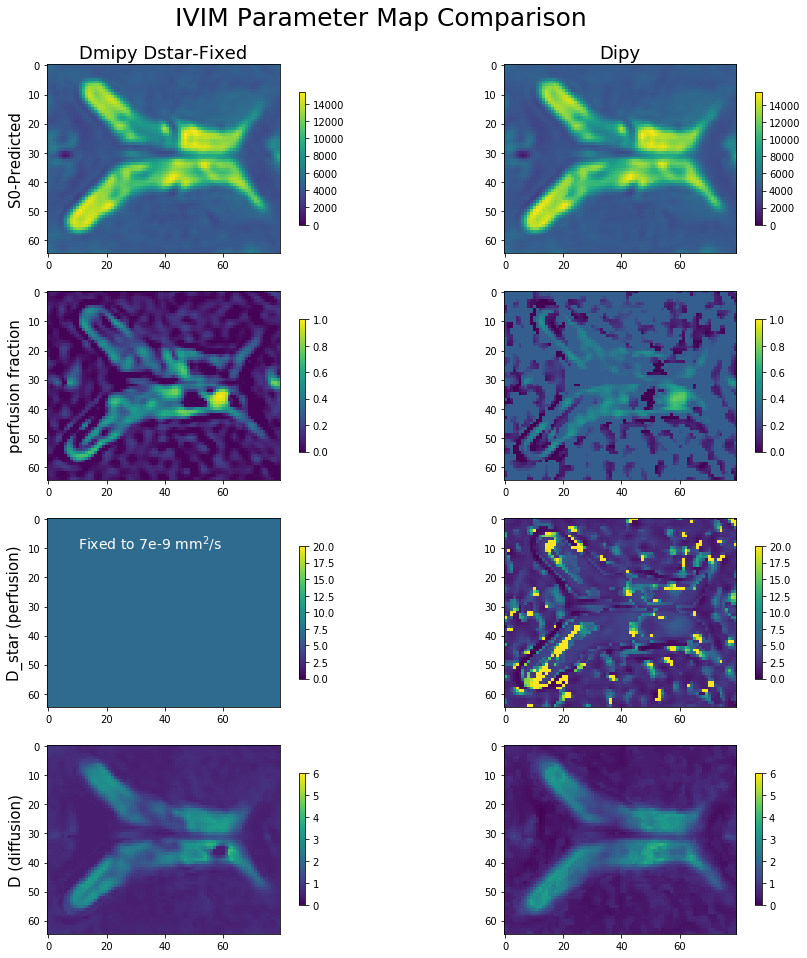

In [7]:
import numpy as np
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=[15, 16])
fig.suptitle('IVIM Parameter Map Comparison', fontsize=25, y=0.93)
axs = axs.ravel()
axs[0].set_title('Dmipy Dstar-Fixed', fontsize=18)
axs[1].set_title('Dipy', fontsize=18)
axs[0].set_ylabel('S0-Predicted', fontsize=15)
axs[2].set_ylabel('perfusion fraction', fontsize=15)
axs[4].set_ylabel('D_star (perfusion)', fontsize=15)
axs[6].set_ylabel('D (diffusion)', fontsize=15)

args = {'vmin': 0., 'interpolation': 'nearest'}
im0 = axs[0].imshow(ivim_fit_dmipy_fixed.S0, **args)
im1 = axs[1].imshow(ivim_fit_dipy.S0_predicted, **args)
im2 = axs[2].imshow(ivim_fit_dmipy_fixed.fitted_parameters['partial_volume_1'], vmax=1., **args)
im3 = axs[3].imshow(ivim_fit_dipy.perfusion_fraction, vmax=1., **args)
im4 = axs[4].imshow(np.ones_like(ivim_fit_dmipy_fixed.S0) * 
                    ivim_fit_dmipy_fixed.fitted_and_linked_parameters['G1Ball_2_lambda_iso'] * 1e9, vmax=20, **args)
axs[4].text(10, 10, 'Fixed to 7e-9 mm$^2$/s', fontsize=14, color='white')
im5 = axs[5].imshow(ivim_fit_dipy.D_star * 1e3, vmax=20, **args)
im6 = axs[6].imshow(ivim_fit_dmipy_fixed.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmax=6, **args)
im7 = axs[7].imshow(ivim_fit_dipy.D * 1e3, vmax=6, **args)

for im, ax in zip([im0, im1, im2, im3, im4, im5, im6, im7], axs):
    fig.colorbar(im, ax=ax, shrink=0.7)

Notice that the two algorithms have basically the same S0 estimation, but differences can be found in the other maps. 

Interestingly, the Dipy IVIM algorithm finds overall higher perfusion volume fractions -- sort of clustered around 0.25 -- than the Dmipy implementation, as well as extremely high D-star values outside of the optimization range.

Our findings become more clear in the following parameter histograms in the example slice:

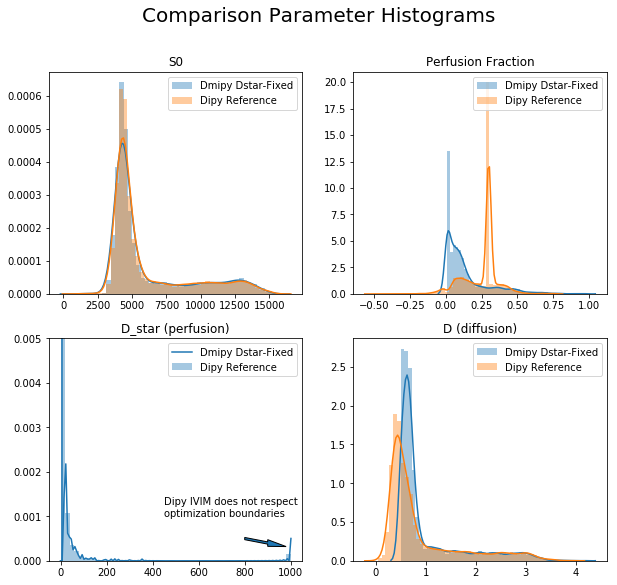

In [10]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=[10, 9])
fig.suptitle('Comparison Parameter Histograms', fontsize=20)
axs = axs.ravel()
sns.distplot(ivim_fit_dmipy_fixed.S0.ravel(), ax=axs[0], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.S0_predicted.ravel(), ax=axs[0], label='Dipy Reference')
axs[0].set_title('S0')

sns.distplot(ivim_fit_dmipy_fixed.fitted_parameters['partial_volume_1'].ravel(), ax=axs[1], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.perfusion_fraction.ravel(), ax=axs[1], label='Dipy Reference')
axs[1].set_title('Perfusion Fraction')

axs[2].axvline(x=7, label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.D_star.ravel() * 1e3, ax=axs[2], label='Dipy Reference')
axs[2].set_ylim(0, 0.005)
axs[2].set_title('D_star (perfusion)')
axs[2].text(450, 0.001, 'Dipy IVIM does not respect\noptimization boundaries')
axs[2].arrow(800, 0.0005, 100, -0.0001, width=0.00005, head_length=80.)

sns.distplot(ivim_fit_dmipy_fixed.fitted_parameters['G1Ball_1_lambda_iso'].ravel() * 1e9, ax=axs[3], label='Dmipy Dstar-Fixed')
sns.distplot(ivim_fit_dipy.D.ravel() * 1e3, ax=axs[3], label='Dipy Reference')
axs[3].set_title('D (diffusion)')

[ax.legend() for ax in axs];

In the histograms notice again that the 2 Dmipy implementations find similar parameter values, and the Dipy implementation differs.
- S0 is basically the same for all algorithms.
- Perfusion fraction are lower for Dmipy IVIM, and Dipy IVIM finds a very particular peak just above 0.25.
- D_star is fixed to 7e-9 $m^2$/s for D-star-fixed algorithm, but Dipy's D_star values sometimes find values of 1000 (i.e. 3000 $mm^2/s$, 1000 times free water diffusivity).
- For regular D estimation, Dipy IVIM being somewhat lower overall compared to Dmipy's.

### Fitting error comparison

Following our previous findings we can also calculate the mean squared fitting error for the three algorithms.

In [11]:
mse_Dstar_fixed = ivim_fit_dmipy_fixed.mean_squared_error(data_slice)
mse_dipy = np.mean(
    (ivim_fit_dipy.predict(gtab) / ivim_fit_dipy.S0_predicted[..., None] - 
     data_slice / ivim_fit_dipy.S0_predicted[..., None]) ** 2, axis=-1)

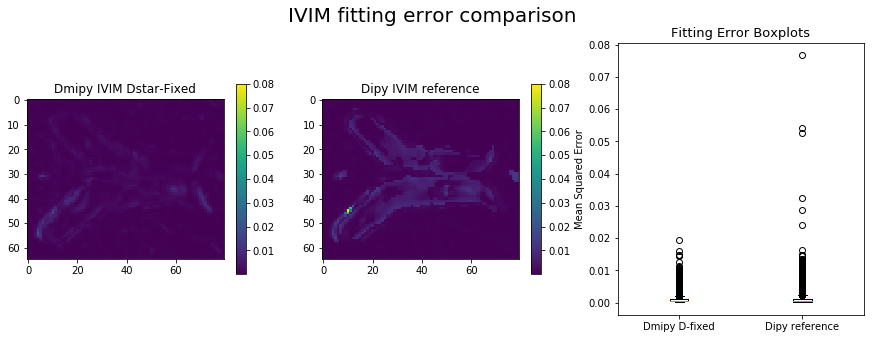

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15, 5])
fig.suptitle('IVIM fitting error comparison', fontsize=20)
axs = axs.ravel()
im0 = axs[0].imshow(mse_Dstar_fixed, vmax=0.08)
im1 = axs[1].imshow(mse_dipy, vmax=0.08)

axs[0].set_title('Dmipy IVIM Dstar-Fixed')
axs[1].set_title('Dipy IVIM reference')

for im, ax in zip([im0, im1], axs):
    fig.colorbar(im, ax=ax, shrink=0.7)

axs[2].boxplot(
    x=[mse_Dstar_fixed.ravel(), mse_dipy.ravel()],
    labels=['Dmipy D-fixed', 'Dipy reference']);
axs[2].set_ylabel('Mean Squared Error')
axs[2].set_title('Fitting Error Boxplots', fontsize=13);

Dmipy's IVIM implementation has overall lower fitting error than Dipy's implementation -- which shows some extreme outliers even.

This example demonstrated that Dmipy can be easily used to generate, fit and evaluate the IVIM model. Without commenting on any implementation's correctness (no ground truth), we at least showed that Dmipy respects the parameter value boundaries that we impose during the optimization.

#### References
- Le Bihan, D., Breton, E., Lallemand, D., Aubin, M. L., Vignaud, J., & Laval-Jeantet, M. (1988). Separation of diffusion and perfusion in intravoxel incoherent motion MR imaging. Radiology, 168(2), 497-505.
- Le Bihan, D. (2017). What can we see with IVIM MRI?. NeuroImage
- Gurney-Champion OJ, Froeling M, Klaassen R, Runge JH, Bel A, Van Laarhoven HWM, et al. Minimizing the Acquisition Time for Intravoxel Incoherent Motion Magnetic Resonance Imaging Acquisitions in the Liver and Pancreas. Invest Radiol. 2016;51: 211–220.
- Park HJ, Sung YS, Lee SS, Lee Y, Cheong H, Kim YJ, et al. Intravoxel incoherent motion diffusion-weighted MRI of the abdomen: The effect of fitting algorithms on the accuracy and reliability of the parameters. J Magn Reson Imaging. 2017;45: 1637–1647.
- Wong, S. M., Backes, W. H., Zhang, C. E., Staals, J., van Oostenbrugge, R. J., Jeukens, C. R. L. P. N., & Jansen, J. F. A. (2018). On the Reproducibility of Inversion Recovery Intravoxel Incoherent Motion Imaging in Cerebrovascular Disease. American Journal of Neuroradiology.
- Gurney-Champion, O. J., Klaassen, R., Froeling, M., Barbieri, S., Stoker, J., Engelbrecht, M. R., ... & Nederveen, A. J. (2018). Comparison of six fit algorithms for the intra-voxel incoherent motion model of diffusion-weighted magnetic resonance imaging data of pancreatic cancer patients. PloS one, 13(4), e0194590.